In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random

%matplotlib inline

np.random.seed(2017)

## Dataset

### Get the Data

In [172]:
from keras.datasets import cifar10

#### CIFAR10 small image classification

Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

In [173]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, l in enumerate(label_names):
    print("{}: {}".format(i,l))

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


 We need to split all the data into three sets: training, test, and validation. Roughly speaking, the training set will have 80% of the data and 10% for the other two.

In [174]:
(x_other, y_other), (X_test, Y_test) = cifar10.load_data()

In [175]:
print("Training set shape: {}".format(x_other.shape))
print("Test set shape: {}".format(X_test.shape))

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [176]:
# Now we need to further split the training set to get our validation set
from sklearn.model_selection import train_test_split

In [177]:
X_train, X_val, Y_train, Y_val = train_test_split(x_other, y_other, test_size=0.20, random_state=14)

In [178]:
print("Training set shape: {}".format(X_train.shape))
print("Test set shape: {}".format(X_test.shape))
print("Validation set shape: {}".format(X_val.shape))

Training set shape: (40000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)


#### Explore the data

In [179]:
sample_id = np.random.randint(0, len(X_train))
sample_image = X_train[sample_id]
sample_label = Y_train[sample_id][0]


Example of Image 38502:
Image - Min Value: 6 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


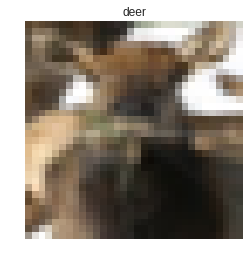

In [305]:
print('\nExample of Image {}:'.format(sample_id))
print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
print('Image - Shape: {}'.format(sample_image.shape))
print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
plt.axis('off')
plt.imshow(sample_image)
plt.title(label_names[sample_label])

## Preprocessing

In [181]:
import pickle

In [182]:
def normalize(x):
    """
    Normalize pixels around center
    """
#     return x / np.max(x)
    return x / 255

In [183]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    labels = np.zeros((10,10))
    np.fill_diagonal(labels,1)
    
    one_hot = np.zeros((len(x), 10))
    
    for i, sample in enumerate(x):
        one_hot[i] = labels[sample]
    
    return one_hot

In [184]:
example = np.array([1, 2, 3, 4, 5, 6, 7, 8, 1, 3])
one_hot_encode(example)

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [185]:
def preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)
    
    pickle.dump((features, labels), open(filename, 'wb'))

In [186]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [187]:
# Train Data
preprocess_and_save(normalize, one_hot_encode, X_train, Y_train, 'preprocess_train.p')

In [188]:
# Validation Data
preprocess_and_save(normalize, one_hot_encode, X_val, Y_val, 'preprocess_validation.p')

In [189]:
# Test Data
preprocess_and_save(normalize, one_hot_encode, X_test, Y_test, 'preprocess_test.p')

### Checkpoint

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

# Load the Preprocessed data
train_features, train_labels = pickle.load(open('preprocess_train.p', mode='rb'))
test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build The Network

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation

Using TensorFlow backend.


In [4]:
# img info
img_width = 32
img_height = 32
channels = 3

# label information
num_classes = train_labels.shape[1]

# Model Hyperparamets
ksize = (3, 3)
strides = 1

psize = (2, 2)
pstrides = 2
pad = 'SAME'

dropout_rate = 0.25

In [5]:
model = Sequential()

# Conv Layer 1
model.add(
    Conv2D(filters=32, kernel_size=ksize, padding=pad,
           strides=strides, input_shape=(img_width, img_height, channels))
)
model.add(Activation('relu'))


# Conv Layer 2
model.add(
    Conv2D(filters=32, kernel_size=ksize, padding=pad, strides=strides)
)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=psize, padding=pad, strides=pstrides))
model.add(Dropout(dropout_rate))

# Conv Layer 3
model.add(
    Conv2D(filters=64, kernel_size=ksize, padding=pad, strides=strides)
)
model.add(Activation('relu'))

# Conv Layer 4
model.add(
    Conv2D(filters=64, kernel_size=ksize, padding=pad, strides=strides)
)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=psize, padding=pad, strides=pstrides))
model.add(Dropout(dropout_rate))

# Conv Layer 5
model.add(
    Conv2D(filters=128, kernel_size=ksize, padding=pad, strides=strides)
)
model.add(Activation('relu'))

# Conv Layer 6
model.add(
    Conv2D(filters=128, kernel_size=ksize, padding=pad, strides=strides)
)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=psize, padding=pad, strides=pstrides))
model.add(Dropout(dropout_rate))

# GAP - Flatten
model.add(GlobalAveragePooling2D())

# Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(.5))

# Dense Layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(.5))

# Output Layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

### Train the Model

In [6]:
# Tune Parameters
epochs = 100
batch_size = 128

his_freq = batch_size // 8

# Model saving
weights_path = 'saved_models/weights.best.from_sratch.hdf5'
model_path = 'saved_models/model.from_scratch.json'

data_augmentation = True

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [301]:
callbacks_list = [
    ModelCheckpoint(filepath=weights_path, 
                               verbose=1, monitor='val_acc', save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=15, verbose=0),
    TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_images=True)
]

In [302]:
if not data_augmentation:
    print("Not using data augmentation.")
    start = time.time()
    train_hist = model.fit(
        train_features,
        train_labels,
        batch_size = batch_size,
        epochs = epochs,
        shuffle= True,
        callbacks = callbacks_list,
        validation_data = (valid_features, valid_labels),
        verbose = 2
    )
else:
    from keras.preprocessing.image import ImageDataGenerator
    print("Using data augmentation")
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
        zoom_range = 0.2, # randomly zoom
    )
    
    datagen.fit(train_features)
    
    start = time.time()
    train_hist = model.fit_generator(
        datagen.flow(train_features, train_labels, batch_size=batch_size),
        steps_per_epoch=train_features.shape[0] // batch_size,
        epochs=epochs,
        validation_data=(valid_features, valid_labels),
        callbacks=callbacks_list,
        verbose=2
    )

end = time.time()

Using data augmentation
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.10380, saving model to saved_models/weights.best.from_sratch.hdf5
10s - loss: 1.7629 - acc: 0.3293 - val_loss: 3.1940 - val_acc: 0.1038
Epoch 2/100
Epoch 00001: val_acc improved from 0.10380 to 0.55860, saving model to saved_models/weights.best.from_sratch.hdf5
9s - loss: 1.3801 - acc: 0.4975 - val_loss: 1.2287 - val_acc: 0.5586
Epoch 3/100
Epoch 00002: val_acc did not improve
9s - loss: 1.2231 - acc: 0.5635 - val_loss: 1.3150 - val_acc: 0.5355
Epoch 4/100
Epoch 00003: val_acc improved from 0.55860 to 0.58920, saving model to saved_models/weights.best.from_sratch.hdf5
9s - loss: 1.1160 - acc: 0.6058 - val_loss: 1.1681 - val_acc: 0.5892
Epoch 5/100
Epoch 00004: val_acc improved from 0.58920 to 0.67420, saving model to saved_models/weights.best.from_sratch.hdf5
9s - loss: 1.0488 - acc: 0.6324 - val_loss: 0.9038 - val_acc: 0.6742
Epoch 6/100
Epoch 00005: val_acc did not improve
9s - loss: 1.0004 - acc: 0.6495

Epoch 00056: val_acc did not improve
9s - loss: 0.4517 - acc: 0.8488 - val_loss: 0.4314 - val_acc: 0.8529
Epoch 58/100
Epoch 00057: val_acc improved from 0.85590 to 0.86610, saving model to saved_models/weights.best.from_sratch.hdf5
9s - loss: 0.4535 - acc: 0.8451 - val_loss: 0.3992 - val_acc: 0.8661
Epoch 59/100
Epoch 00058: val_acc did not improve
9s - loss: 0.4482 - acc: 0.8483 - val_loss: 0.4270 - val_acc: 0.8565
Epoch 60/100
Epoch 00059: val_acc did not improve
9s - loss: 0.4483 - acc: 0.8487 - val_loss: 0.4065 - val_acc: 0.8639
Epoch 61/100
Epoch 00060: val_acc did not improve
9s - loss: 0.4434 - acc: 0.8507 - val_loss: 0.4265 - val_acc: 0.8530
Epoch 62/100
Epoch 00061: val_acc did not improve
9s - loss: 0.4437 - acc: 0.8511 - val_loss: 0.4348 - val_acc: 0.8496
Epoch 63/100
Epoch 00062: val_acc did not improve
9s - loss: 0.4361 - acc: 0.8525 - val_loss: 0.4428 - val_acc: 0.8501
Epoch 64/100
Epoch 00063: val_acc improved from 0.86610 to 0.87090, saving model to saved_models/weight

In [303]:
print("Model took {:.2f} seconds to train".format(end - start))

# get index of predicted class for each image in test set
model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_labels, axis=1))/len(model_predictions)
print("Test accuracy: {:.2f}%".format(test_accuracy))

Model took 925.76 seconds to train
Test accuracy: 84.84%


In [8]:
# serialize model to JSON
model_json = model.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_json)
    print("Model saved as JSON")

Model saved as JSON


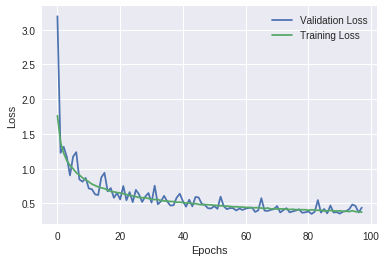

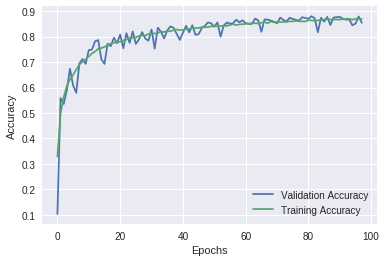

In [304]:
epochs_ = len(train_hist.history['val_acc'])

# Plot learning curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(epochs_), train_hist.history['val_loss'], label='Validation Loss')
plt.plot(range(epochs_), train_hist.history['loss'], label='Training Loss')
plt.legend(loc="best")

# Plot accuracy curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(epochs_), train_hist.history['val_acc'], label='Validation Accuracy')
plt.plot(range(epochs_), train_hist.history['acc'], label='Training Accuracy')
plt.legend(loc="best")

## Build The Transfer Learning Model

In [1]:
import pickle 
import os
import matplotlib.pyplot as plt
import scipy
import seaborn
import numpy as np
import time

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import (Dropout, Flatten, Dense, Input, Activation,
                          Conv2D, GlobalAveragePooling2D)
from keras.models import Sequential
from keras.datasets import cifar10

%matplotlib inline

Using TensorFlow backend.


In [9]:
(x_other, y_other), (test_features, test_labels) = cifar10.load_data()

In [10]:
print("Training set shape: {}".format(x_other.shape))
print("Test set shape: {}".format(test_features.shape))

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [11]:
# Now we need to further split the training set to get our validation set
from sklearn.model_selection import train_test_split

In [12]:
train_features, valid_features, train_labels, valid_labels = train_test_split(x_other, y_other, test_size=0.20, random_state=14)

In [13]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    labels = np.zeros((10,10))
    np.fill_diagonal(labels,1)
    
    one_hot = np.zeros((len(x), 10))
    
    for i, sample in enumerate(x):
        one_hot[i] = labels[sample]
    
    return one_hot

### Calculate bottleneck features

In [8]:
# load the inceptionV3 model and remove the final classification layer
base_model = InceptionV3(include_top=False,
                       weights='imagenet',
                       input_shape=(139, 139, 3))
print("model loaded")

model loaded


In [14]:
# get bottleneck features (train)
train_filename = 'inceptionv3_features_train.npz'

if os.path.exists(train_filename):
    print("bottleneck features detected (train)")
    print("loading...")
    train_features = np.load(train_filename)['features']
else:
    print("bottleneck features file not detected (train)")
    print("calculating now and loading...")
    # pre-process train data
    big_x_train = np.array([scipy.misc.imresize(train_features[i], (139, 139, 3))
                           for i in range(0, len(train_features))]).astype('float32')
    inceptionv3_input_train = preprocess_input(big_x_train)
    train_features = base_model.predict(inceptionv3_input_train)
    train_features = np.squeeze(train_features)
    np.savez(train_filename, features=train_features)
    print("bottleneck features saved (train)")

bottleneck features detected (train)
loading...


In [15]:
# get bottleneck features (test)
test_filename = 'inceptionv3_features_test.npz'

if os.path.exists(test_filename):
    print("bottleneck features detected (test)")
    test_features = np.load(test_filename)['features']
else:
    print("bottleneck features file not detected (test)")
    print("calculating now and loading...")
    # pre-process train data
    big_x_test = np.array([scipy.misc.imresize(test_features[i], (139, 139, 3))
                       for i in range(0, len(test_features))]).astype('float32')
    inceptionv3_input_test = preprocess_input(big_x_test)
    test_features = base_model.predict(inceptionv3_input_test)
    test_features = np.squeeze(test_features)
    np.savez(test_filename, features=test_features)
    print("bottleneck features saved (test)")

bottleneck features detected (test)


In [16]:
# get bottleneck features (test)
val_filename = 'inceptionv3_features_val.npz'

if os.path.exists(val_filename):
    print("bottleneck features detected (val)")
    valid_features = np.load(val_filename)['features']
else:
    print("bottleneck features file not detected (val)")
    print("calculating now and loading...")
    # pre-process train data
    big_x_val = np.array([scipy.misc.imresize(valid_features[i], (139, 139, 3))
                   for i in range(0, len(valid_features))]).astype('float32')
    inceptionv3_input_val = preprocess_input(big_x_val)
    valid_features = base_model.predict(inceptionv3_input_val)
    valid_features = np.squeeze(valid_features)
    np.savez(val_filename, features=valid_features)
    print("bottleneck features saved (val)")

bottleneck features detected (val)


In [17]:
print("Training set shape: {}".format(train_features.shape))
print("Test set shape: {}".format(test_features.shape))
print("Validation set shape: {}".format(valid_features.shape))

Training set shape: (40000, 3, 3, 2048)
Test set shape: (10000, 3, 3, 2048)
Validation set shape: (10000, 3, 3, 2048)


In [24]:
from tsne import bh_sne

# reshape bottleneck features + reduce dimensionality with t-SNE
if os.path.exists('tsne_features.npz'):
    print('tsne features detected (test)')
    tsne_features = np.load('tsne_features.npz')['tsne_features']
else:
    print('tsne features not detected (test)')
    print('calculating now ...')
    tsne_features = bh_sne(train_features.reshape([train_features.shape[0], np.prod(train_features.shape[1:])]).astype('float64')[:25000])
    np.savez('tsne_features', tsne_features=tsne_features)
print('tsne features obtained')

tsne features detected (test)
tsne features obtained


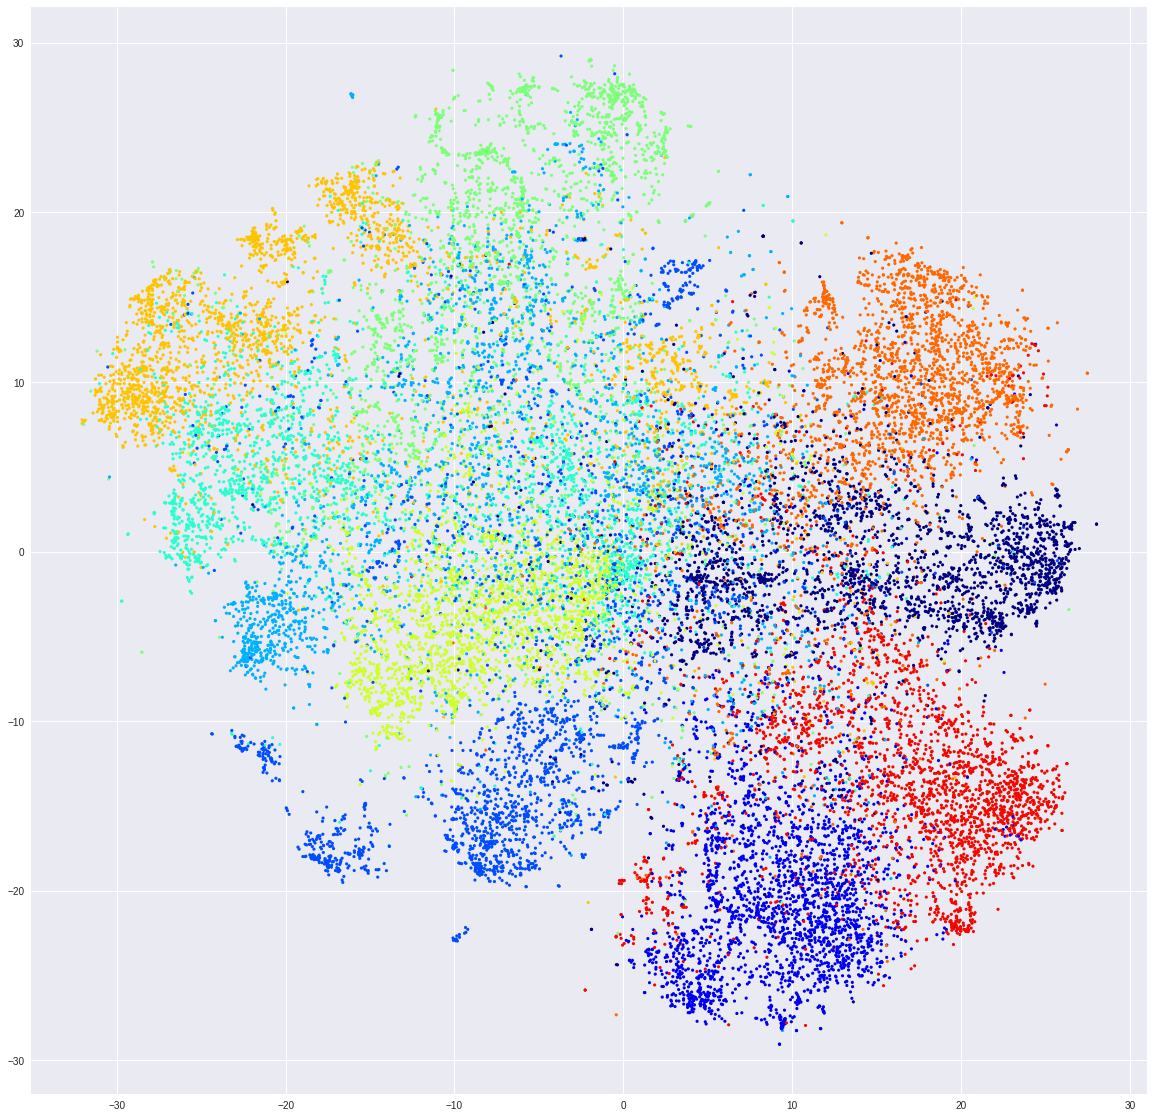

In [36]:
# plot the features
plt.figure(figsize=(20,20))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=plt.cm.jet(np.squeeze(train_labels)/10), s=10, edgecolors='none')
plt.show()

#### Build Inception Network to Extract Features From

In [18]:
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)
valid_labels = one_hot_encode(valid_labels)

In [19]:
# label information
num_classes = train_labels.shape[1]

In [20]:
inceptionv3_model = Sequential()

inceptionv3_model.add(Conv2D(filters=128, kernel_size=2, input_shape=train_features.shape[1:]))
inceptionv3_model.add(Dropout(0.4))
inceptionv3_model.add(GlobalAveragePooling2D())
# inceptionv3_model.add(Dense(256))
# inceptionv3_model.add(Activation('relu'))
inceptionv3_model.add(Dropout(0.3))
inceptionv3_model.add(Dense(num_classes))
inceptionv3_model.add(Activation('softmax'))
    
inceptionv3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 2, 128)         1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 1,049,994
Trainable params: 1,049,994
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Tune Parameters
epochs = 100
batch_size = 64
nb_epoch = epochs // 10

# Model saving
inception_weights_path = 'saved_models/weights.best.inceptionv3.hdf5'
inception_model_path = 'saved_models/model.inceptionv3.json'

In [22]:
inceptionv3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
callbacks_list = [
    ModelCheckpoint(filepath=inception_weights_path, 
                               verbose=1, monitor='val_acc', save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=10, verbose=0),
    TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_images=True)
]

In [40]:
start = time.time()
train_hist = inceptionv3_model.fit(
    train_features,
    train_labels,
    batch_size = batch_size,
    epochs = epochs,
    shuffle= True,
    callbacks = callbacks_list,
    validation_data = (valid_features, valid_labels),
    verbose = 2
)
end = time.time()

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.78920, saving model to saved_models/weights.best.inceptionv3.hdf5
4s - loss: 5.0864 - acc: 0.6449 - val_loss: 2.9217 - val_acc: 0.7892
Epoch 2/100
Epoch 00001: val_acc improved from 0.78920 to 0.79090, saving model to saved_models/weights.best.inceptionv3.hdf5
4s - loss: 3.2530 - acc: 0.7713 - val_loss: 3.0147 - val_acc: 0.7909
Epoch 3/100
Epoch 00002: val_acc improved from 0.79090 to 0.79530, saving model to saved_models/weights.best.inceptionv3.hdf5
4s - loss: 3.1099 - acc: 0.7847 - val_loss: 2.9532 - val_acc: 0.7953
Epoch 4/100
Epoch 00003: val_acc improved from 0.79530 to 0.79660, saving model to saved_models/weights.best.inceptionv3.hdf5
4s - loss: 3.0435 - acc: 0.7917 - val_loss: 2.9775 - val_acc: 0.7966
Epoch 5/100
Epoch 00004: val_acc improved from 0.79660 to 0.80990, saving model to saved_models/weights.best.inceptionv3.hdf5
4s - loss: 3.0465 - acc: 0.7938 - val_loss: 2.8

#### Test the Model

In [41]:
print("Model took {:.2f} seconds to train".format(end - start))

# get index of predicted class for each image in test set
inceptionv3_predictions = [np.argmax(inceptionv3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inceptionv3_predictions)==np.argmax(test_labels, axis=1))/len(inceptionv3_predictions)
print("Test accuracy: {:.2f}%".format(test_accuracy))

Model took 212.82 seconds to train
Test accuracy: 81.56%


In [24]:
# serialize model to JSON
inceptionv3_model_json = inceptionv3_model.to_json()
with open(inception_model_path, "w") as json_file:
    json_file.write(inceptionv3_model_json)
    print("Model saved as JSON")

Model saved as JSON


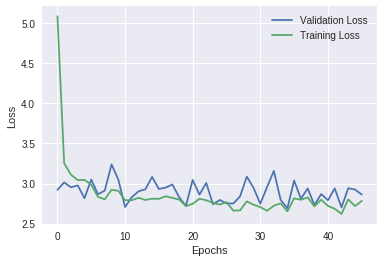

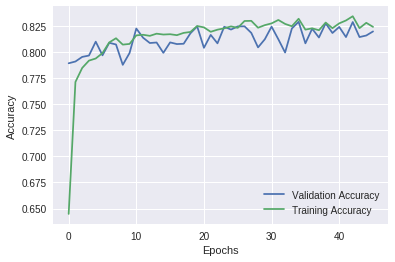

In [42]:
epochs_ = len(train_hist.history['val_acc'])

# Plot learning curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(epochs_), train_hist.history['val_loss'], label='Validation Loss')
plt.plot(range(epochs_), train_hist.history['loss'], label='Training Loss')
plt.legend(loc="best")

# Plot accuracy curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(epochs_), train_hist.history['val_acc'], label='Validation Accuracy')
plt.plot(range(epochs_), train_hist.history['acc'], label='Training Accuracy')
plt.legend(loc="best")

#### Load the Model with the Best Validation Loss

In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json

%matplotlib inline

# Scratch Model
weights_path = 'saved_models/weights.best.from_sratch.hdf5'
model_path = 'saved_models/model.from_scratch.json'

# Inception Model
inception_weights_path = 'saved_models/weights.best.inceptionv3.hdf5'
inception_model_path = 'saved_models/model.inceptionv3.json'

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [15]:
def preprocess_image(image_path, preprocess_input, resize_shape):
    img = load_img(image_path)
    img = img_to_array(img)
    img = scipy.misc.imresize(img, size=resize_shape)
    img = preprocess_input(img)
    return img

In [2]:
with open(model_path, 'r') as model_json:
    loaded_model = model_from_json(model_json.read())

loaded_model.load_weights(weights_path)
print("Scratch Model Loaded")

Scratch Model Loaded


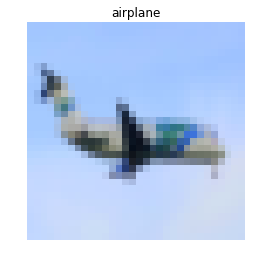

In [16]:
img = preprocess_image('./images/airplane_1.jpg', lambda x: x/255, (32, 32, 3))
pred = label_names[np.argmax(loaded_model.predict(np.expand_dims(img, axis=0)))]

plt.axis('off')
plt.imshow(img)
plt.title(pred)

In [ ]:
with open(inception_model_path, 'r') as model_json:
    loaded_model = model_from_json(model_json.read())

loaded_model.load_weights(inception_weights_path)
print("Inception Model Loaded")